In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
# !wget http://ipsar.fesb.unist.hr/ipsar_data/heridal.zip
# !unzip ./heridal.zip

In [4]:
!ls ../heridal

patches  testImages  trainImages


In [5]:
from drone_sar.ipsar_dataset import IPSARDataset
from drone_sar.lightning_detector import get_lightning_trainer, LightningDetector
from collections import Counter

In [6]:
train_data = IPSARDataset("../heridal/trainImages/")
test_data = IPSARDataset("../heridal/testImages")
item = test_data[0]

In [7]:
len(train_data)

1583

In [8]:
# [it["boxes"] for it in train_data]

In [9]:
# Counter([len(el["boxes"]) for el in train_data])

In [10]:
item.keys()

dict_keys(['img_path', 'pil', 'target_sizes', 'boxes', 'class_labels'])

In [11]:
item["boxes"].shape, item["class_labels"].shape

(torch.Size([2, 4]), torch.Size([2]))

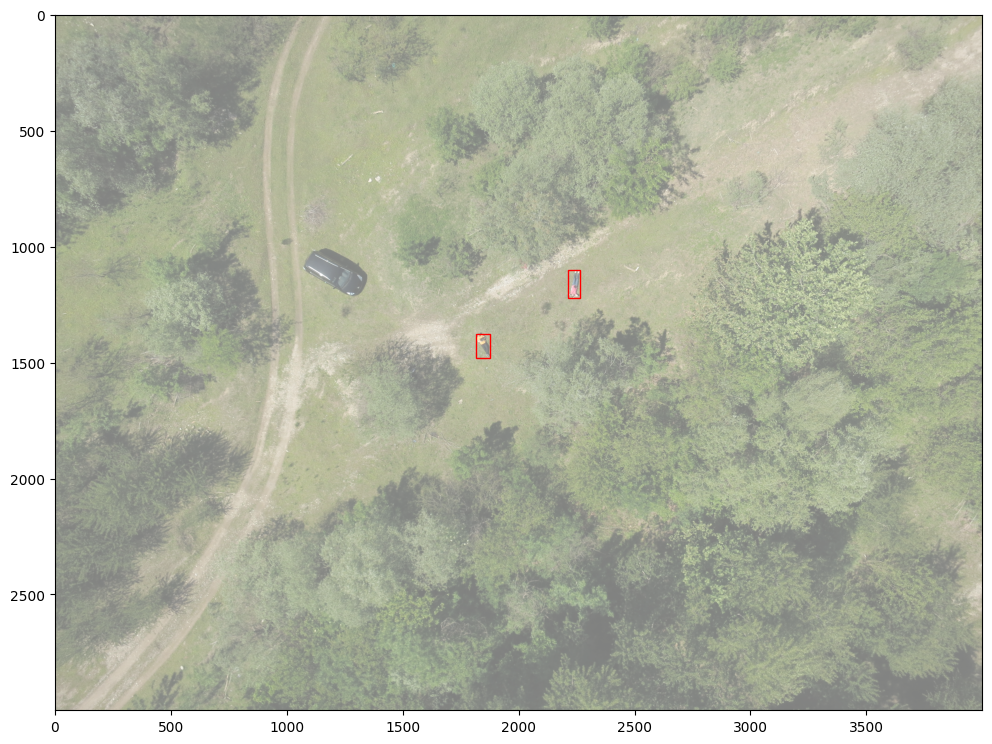

In [12]:
IPSARDataset.plt_show(item, size=10)

In [13]:
lightning_detector = LightningDetector(lr=5e-6)

/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
trainer = get_lightning_trainer("IPSAR-DETR-FIXED", max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
train_dl = train_data.get_dataloader(lightning_detector.processor, bs=10, shuffle=True)
test_dl = test_data.get_dataloader(lightning_detector.processor, bs=10, shuffle=False)

In [16]:
batch, info = next(iter(train_dl))

In [17]:
import torch

In [18]:
len(batch["labels"][0]['boxes'])

0

In [19]:
from tqdm.auto import tqdm

# [torch.isinf(b["boxes"]).all() for batch, _ in tqdm(test_dl) for b in batch["labels"] if len(b["boxes"]) > 0]

In [ ]:
trainer.fit(lightning_detector, train_dataloaders=train_dl, val_dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.037   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [ ]:
outputs_train = trainer.predict(lightning_detector, train_dl)

In [52]:
len(outputs_train)

159

In [ ]:
outputs_val = trainer.predict(lightning_detector, test_dl)

In [53]:
len(outputs_val)

11

In [32]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

'/home/iz/workspace/DroneSearchAndRescue/notebooks/.checkpoints/epoch=33-step=5406.ckpt'

In [20]:
best_model_path = "/home/iz/workspace/DroneSearchAndRescue/notebooks/.checkpoints/epoch=33-step=5406.ckpt"

In [21]:
best_model_state = torch.load(best_model_path)

In [22]:
best_model = LightningDetector.load_from_checkpoint(best_model_path, lr=0.01)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [150]:
test_dl_b1 = test_data.get_dataloader(lightning_detector.processor, bs=1, shuffle=False)
train_dl_b1 = train_data.get_dataloader(lightning_detector.processor, bs=1, shuffle=False)

In [24]:
best_val_outputs = trainer.predict(best_model, test_dl_b1)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [158]:
best_train_outputs = trainer.predict(best_model, train_dl_b1)

In [25]:
len(best_val_outputs)

101

In [159]:
len(best_train_outputs)

1583

In [160]:
# best_train_outputs[2]

In [61]:
import numpy as np

In [215]:
# outputs = best_train_outputs
# target_ds = train_data

outputs = best_val_outputs
target_ds = test_data

In [216]:
loss_sort_index = np.argsort([o["loss"] if o is not None else 100 for o in outputs])

In [217]:
sorted_val_outputs = np.array(outputs)[loss_sort_index]
sorted_val_ds = np.array(list(target_ds))[loss_sort_index]

In [218]:
# IPSARDataset.plt_show(sorted_val_ds[0])

In [220]:
id = 1
target_output = sorted_val_outputs[id]
target_item = sorted_val_ds[id]

In [221]:
target_output["loss"]

tensor(0.0690)

In [222]:
target_output.keys()

odict_keys(['loss', 'loss_dict', 'logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [223]:
post_procesed_out = best_model.processor.post_process_object_detection(
    target_output,
    threshold=0.5,
    target_sizes=[target_item["target_sizes"][::-1]]
)[0]

In [224]:
post_procesed_out

{'scores': tensor([0.8575, 0.9037]),
 'labels': tensor([0, 0]),
 'boxes': tensor([[ 881.9769, 1091.5094, 2730.0046, 3388.9016],
         [ 870.7878, 1061.1089, 2707.7224, 3353.0630]])}

In [225]:
from drone_sar.vis import plt_show

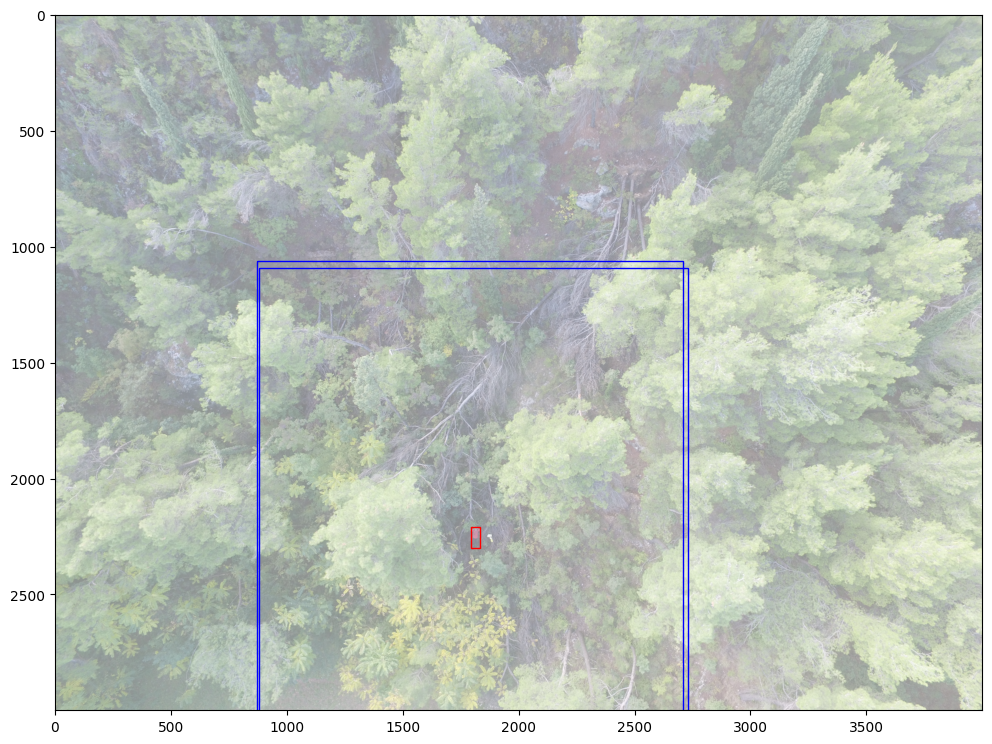

In [226]:
plt_show(target_item["pil"], {"red": target_item["boxes"], "blue": post_procesed_out["boxes"]})

In [117]:
# !rm -rf /home/iz/.cache/joblib/